# Imports

In [102]:
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader 
from torchvision import models, datasets, transforms 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

# Defining constants 

In [103]:
BATCH_SIZE = 10 
TEST_BATCH_SIZE = 100
NUM_CLASSES = 10 # For the CIFAR10 dataset 
LR = 0.001 
EPOCHS = 10

# Creating dataset and DataLoader object

In [104]:
transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
])
train_dset = datasets.CIFAR10(root='data/train', train=True, download=True, transform=transform)
test_dset = datasets.CIFAR10(root='data/test', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=TEST_BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [105]:
class_to_idx = train_dset.class_to_idx
idx_to_class = {x:y for y,x in class_to_idx.items()}
n_classes = len(idx_to_class)

# Displaying a few images

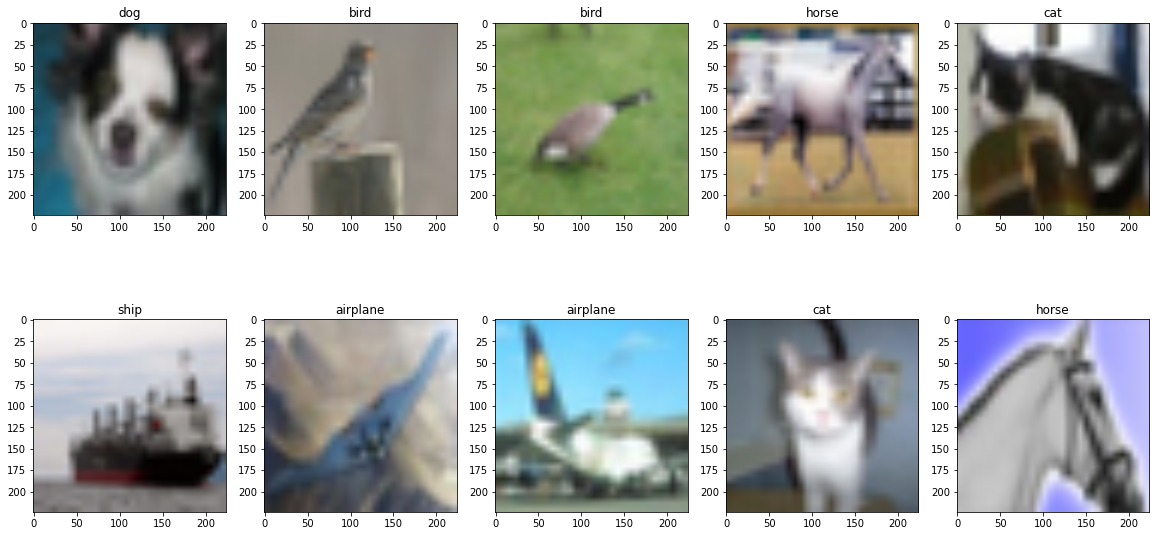

In [106]:
to_pil = transforms.ToPILImage()
sample_images, sample_labels = next(iter(train_loader))
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
ax = ax.flatten()

for axis, sample_image, sample_label in zip(ax, sample_images, sample_labels):
    axis.imshow(to_pil(sample_image))
    axis.set_title(idx_to_class[sample_label.item()])


# Model initialization 

In [107]:
# Any model can be selected for transfer learning. The effectiveness would vary based on the application.
model = models.vgg16(pretrained=True)
# model = models.vgg19(pretrained=True)
# model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.resnet101(pretrained=True)
# model = models.resnet152(pretrained=True)

In [108]:
# The weights need to be frozen so that they do not change while training. 
for p in model.parameters(): 
    p.requires_grad = False 

In [109]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [110]:
# This is the final layer of the model. We can append our custom final layer with the appropriate number of output nodes. 
model.classifier[6] = nn.Sequential(
    nn.Linear(in_features=4096, out_features=1000), 
    nn.ReLU(), 
    nn.Linear(in_features=1000, out_features=n_classes)
)
# Only weights in the final layer need to be changed. This is because the final layer uses the features extracted from previous layers to classify inputs.
# When a new layer is added, requires_grad is set to True by default.

# Defining optimizer and loss function 

In [111]:
opt = optim.Adam(model.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

# Training loop

In [ ]:
for e in range(EPOCHS):
    train_loop = tqdm(train_loader, total=len(train_loader), leave=False, position=0)
    model.train()
    for x,y in train_loop : 
        opt.zero_grad()
        yhat = model.forward(x)
        loss = crit(yhat, y)
        loss.backward()
        opt.step()

        train_loop.set_description(f'Epoch : [{e+1}/{EPOCHS}]')
        train_loop.set_postfix(loss=loss.item())


    test_loop = tqdm(test_loader, total=len(test_loader), leave=False, position=0)
    model.eval()
    for x,y in test_loop : 
        yhat = model.forward(x)
        correct = y == torch.argmax(yhat, dim=1)
        correct = (correct > 0).type(torch.uint8)
        acc = (torch.sum(correct)/len(y)) * 100

        test_loop.set_description(f'Epoch : [{e+1}/{EPOCHS}]')
        test_loop.set_postfix_str(f'Accuracy : {acc}%')